# 1. Setup and Library Imports
The following cell imports all necessary libraries for data processing, visualization, natural language processing, and machine learning. It also checks for GPU availability to optimize training.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_curve, average_precision_score
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')


2025-04-25 11:19:37.440457: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745579977.654557      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745579977.719804      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


GPU is NOT available


2025-04-25 11:19:51.384436: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


# 2. Data Loading and Exploration
This section loads the IFND dataset and performs initial exploration to understand its structure, missing values, and class distribution. This helps in planning our preprocessing and modeling approaches.

In [ ]:
df = pd.read_csv("/kaggle/input/12345678/IFND.csv",encoding='ISO-8859-1')
print(f"Dataset loaded with shape: {df.shape}")

print("\nFirst few rows of the dataset:")
display(df.head())

print("\nMissing values in each column:")
print(df.isnull().sum())

print("\nClass distribution:")
print(df['Label'].value_counts())

Dataset loaded with shape: (56714, 7)

First few rows of the dataset:


,id,Statement,Image,Web,Category,Date,Label
0,2,"WHO praises India's Aarogya Setu app, says it ...",https://cdn.dnaindia.com/sites/default/files/s...,DNAINDIA,COVID-19,Oct-20,TRUE
1,3,"In Delhi, Deputy US Secretary of State Stephen...",https://cdn.dnaindia.com/sites/default/files/s...,DNAINDIA,VIOLENCE,Oct-20,TRUE
2,4,LAC tensions: China's strategy behind delibera...,https://cdn.dnaindia.com/sites/default/files/s...,DNAINDIA,TERROR,Oct-20,TRUE
3,5,India has signed 250 documents on Space cooper...,https://cdn.dnaindia.com/sites/default/files/s...,DNAINDIA,COVID-19,Oct-20,TRUE
4,6,Tamil Nadu chief minister's mother passes away...,https://cdn.dnaindia.com/sites/default/files/s...,DNAINDIA,ELECTION,Oct-20,TRUE



Missing values in each column:
id               0
Statement        0
Image            0
Web              0
Category         0
Date         11321
Label            0
dtype: int64

Class distribution:
Label
TRUE    37800
Fake    18914
Name: count, dtype: int64


# 3. Text Preprocessing
This section implements text preprocessing techniques including lowercasing, removing special characters, stopwords, and stemming. This transforms raw text into a cleaner format suitable for machine learning models.

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

stemmer = SnowballStemmer('english')
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    
    tokens = nltk.word_tokenize(text)
    
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    
    return ' '.join(tokens)

df['processed_text'] = df['Statement'].apply(preprocess_text)

display(df[['Statement', 'processed_text']].head())


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,Statement,processed_text
0,"WHO praises India's Aarogya Setu app, says it ...",prais india aarogya setu app say help identifi...
1,"In Delhi, Deputy US Secretary of State Stephen...",delhi deputi us secretari state stephen biegun...
2,LAC tensions: China's strategy behind delibera...,lac tension china strategi behind deliber fail...
3,India has signed 250 documents on Space cooper...,india sign document space cooper countri isro ...
4,Tamil Nadu chief minister's mother passes away...,tamil nadu chief minist mother pass away


# 4. Feature Extraction and Train-Test Split
This section transforms the preprocessed text into numerical features using TF-IDF vectorization and splits the data into training and testing sets for model evaluation.

In [ ]:
X = df_clean['processed_text']
y = df_clean['Label']

y = y.map({'TRUE': 1, 'True': 1, 'Fake': 0, 'FAKE': 0})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

print("Extracting TF-IDF features...")
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"TF-IDF features shape: {X_train_tfidf.shape}")

Training set size: 37316
Testing set size: 18380
Extracting TF-IDF features...
TF-IDF features shape: (37316, 5000)


# 5. Save cleaned data

In [8]:
cleaned_file_path = 'IFND_cleaned.csv'
df.to_csv(cleaned_file_path, index=False)
print(f"Cleaned dataset saved to {cleaned_file_path}")

Cleaned dataset saved to IFND_cleaned.csv


# 6. Traditional Machine Learning Models
This section implements several traditional machine learning approaches for fake news detection and evaluates their performance.

Evaluating Machine Learning models...

Evaluating Naive Bayes...
Naive Bayes accuracy: 0.9366


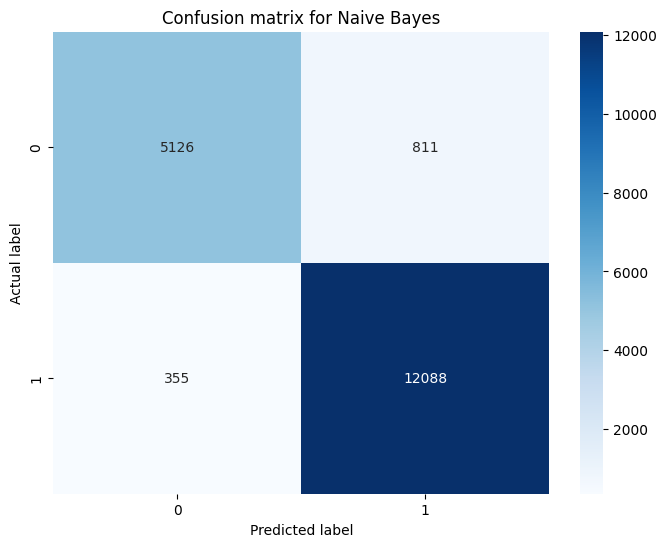

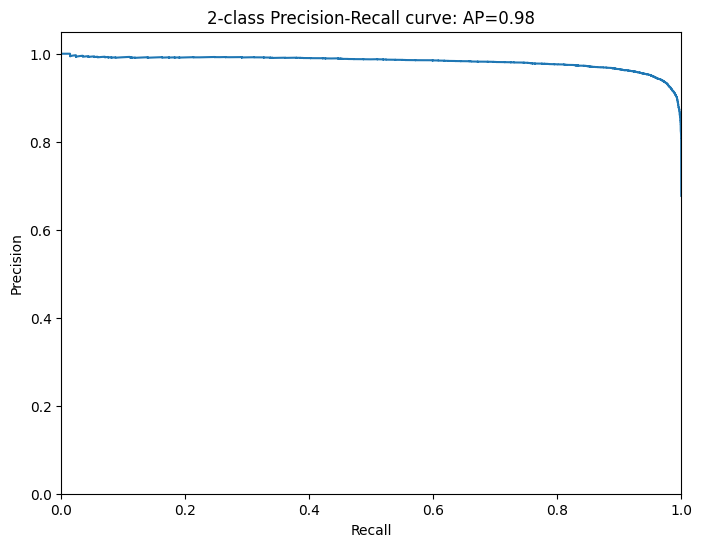


Evaluating Logistic Regression...
Logistic Regression accuracy: 0.9448


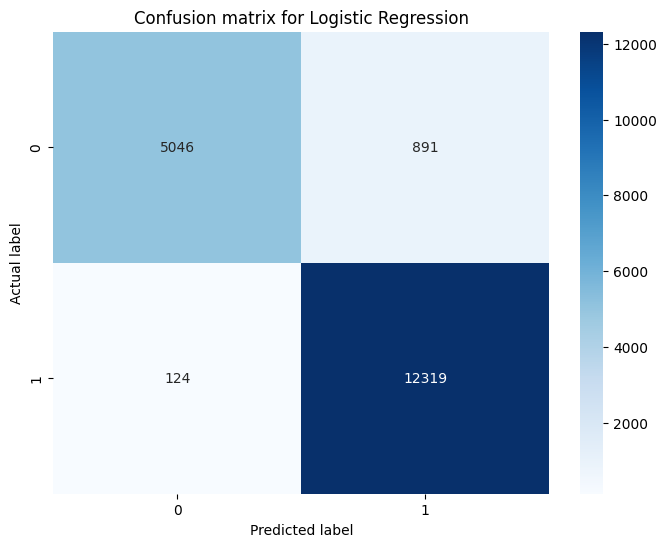

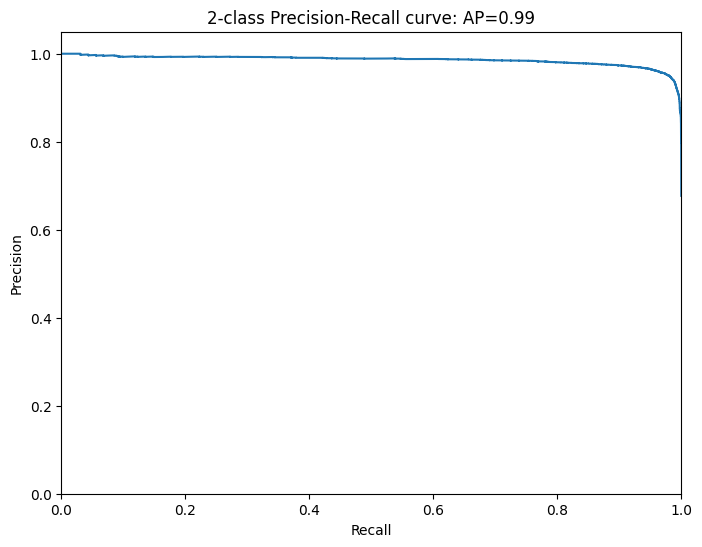


Evaluating Random Forest...
Random Forest accuracy: 0.9520


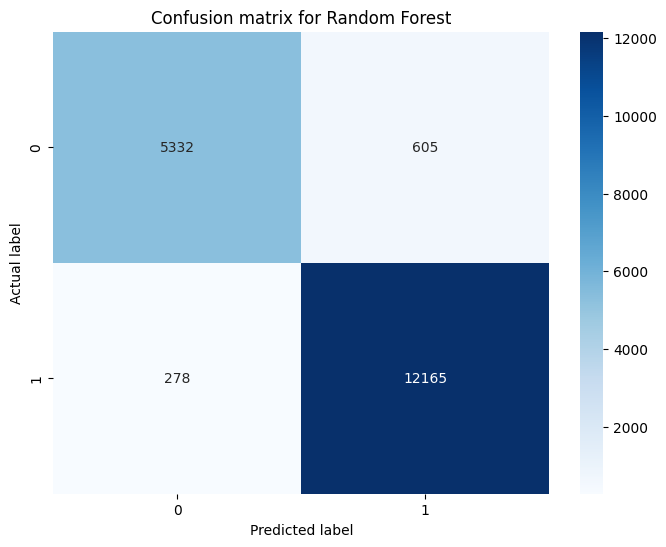

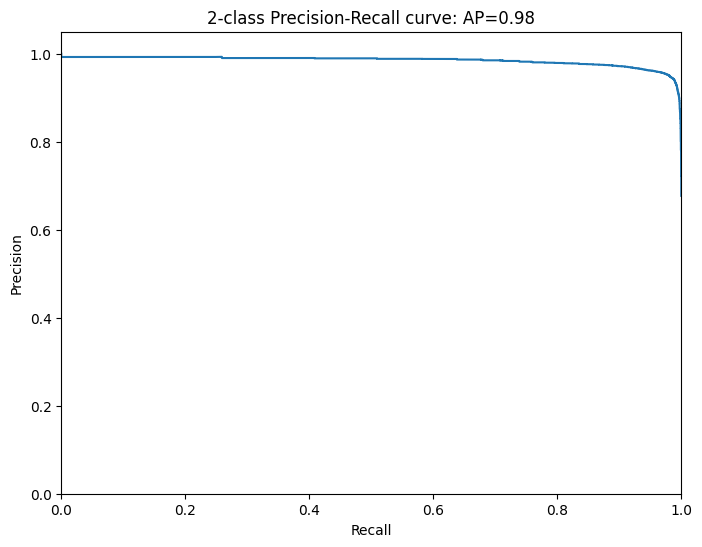


Evaluating Decision Tree...
Decision Tree accuracy: 0.9307


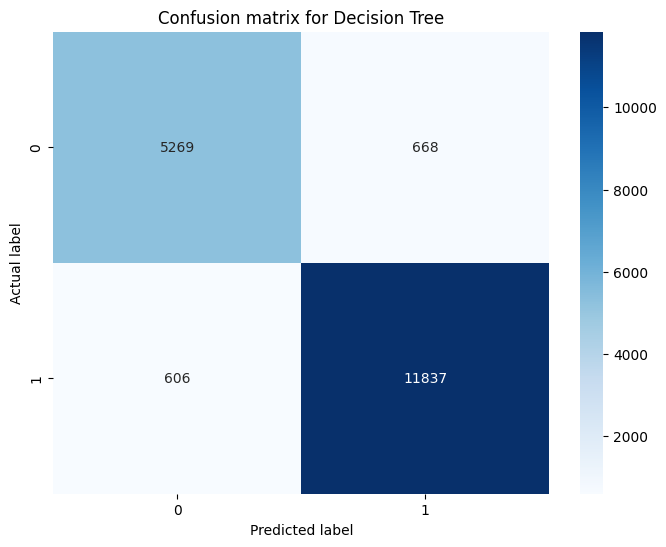

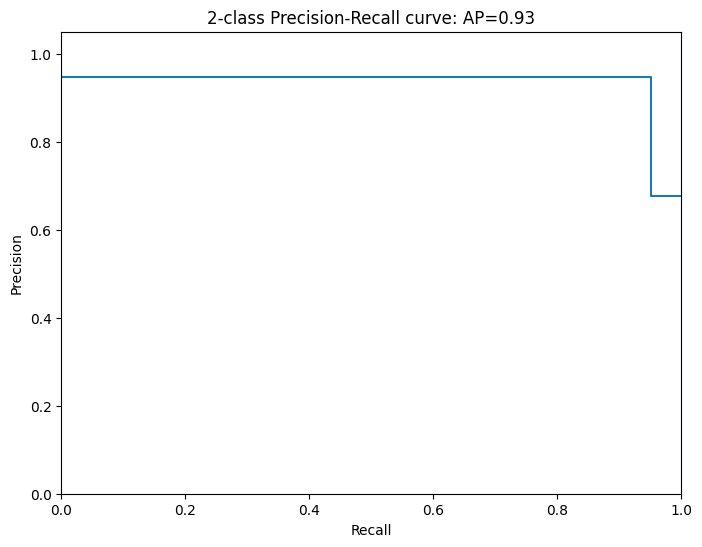


Evaluating KNN...
KNN accuracy: 0.8499


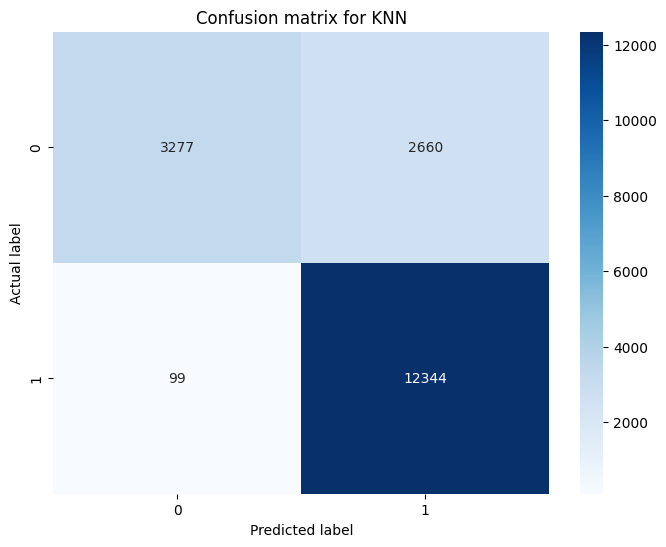

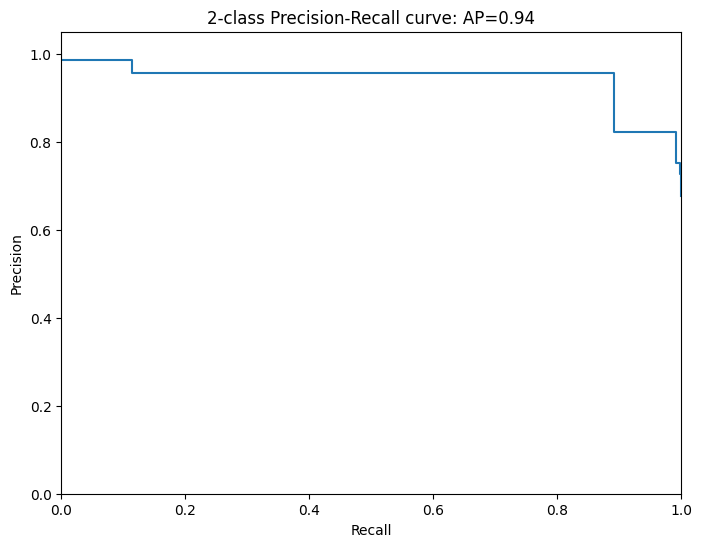

In [ ]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} accuracy: {accuracy:.4f}")
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion matrix for {model_name}')
    plt.xlabel('Predicted label')
    plt.ylabel('Actual label')
    plt.show()
    
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]
        precision, recall, _ = precision_recall_curve(y_test, y_score)
        average_precision = average_precision_score(y_test, y_score)
        
        plt.figure(figsize=(8, 6))
        plt.step(recall, precision, where='post')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title(f'2-class Precision-Recall curve: AP={average_precision:.2f}')
        plt.show()
    
    return accuracy

models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

print("Evaluating Machine Learning models...")
accuracies = {}
for name, model in models.items():
    print(f"\nEvaluating {name}...")
    accuracies[name] = evaluate_model(model, X_train_tfidf, X_test_tfidf, y_train, y_test, name)

# 7. Plot the accuracies of ML models as shown in Figure 20 of the paper


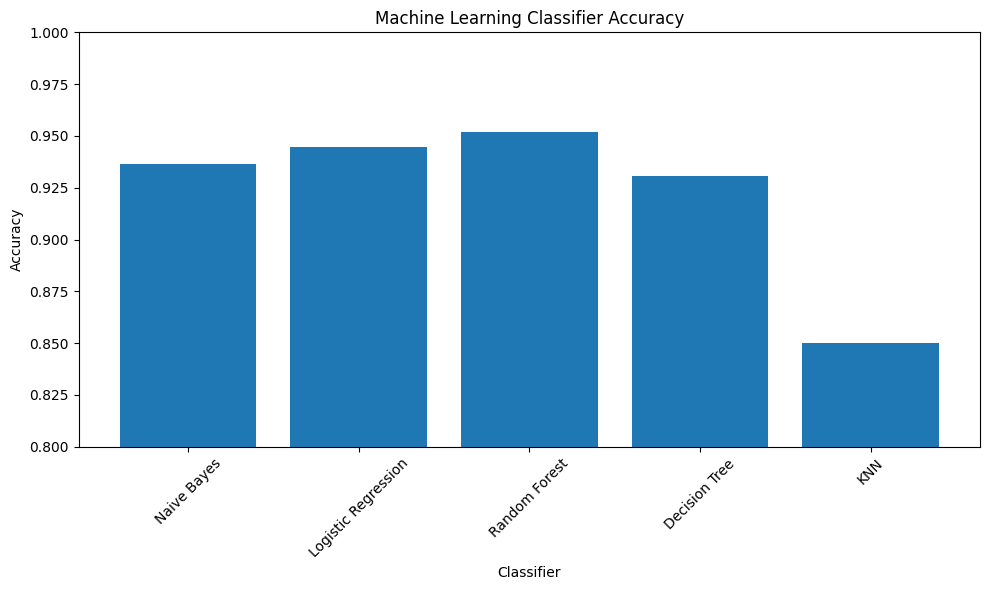

In [10]:
plt.figure(figsize=(10, 6))
plt.bar(accuracies.keys(), accuracies.values())
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.title('Machine Learning Classifier Accuracy')
plt.ylim(0.8, 1.0)  
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 8. Tokenization for Deep Learning
This section prepares the text data for deep learning models by creating numerical sequences.

In [ ]:
print("Preparing data for deep learning models...")
max_len = 50  
vocab_size = 5000  

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

print(f"Padded sequences shape: {X_train_pad.shape}")

import pickle

with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("Tokenizer saved successfully to tokenizer.pkl")

Preparing data for deep learning models...
Padded sequences shape: (37316, 50)
Tokenizer saved successfully to tokenizer.pkl


# 9. Define LSTM and Bi-LSTM architecture

In [ ]:
def create_lstm_model(embedding_dim=40, dropout_rate=0.3):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(100))
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

def create_bilstm_model(embedding_dim=40, dropout_rate=0.3):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len))
    model.add(Dropout(dropout_rate))
    model.add(Bidirectional(LSTM(100)))
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# 10. LSTM model summary

In [14]:
lstm_model = create_lstm_model()
lstm_model.build(input_shape=(None, max_len))
lstm_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 50, 40)              │         200,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50, 40)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 100)                 │          56,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 256,501 (1001.96 KB)

 Trainable params: 256,501 (1001.96 KB)

 Non-trainable params: 0 (0.00 B)

# 11. Bi-LSTM model summary

In [15]:
bilstm_model = create_bilstm_model()
bilstm_model.build(input_shape=(None, max_len))
bilstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 50, 40)              │         200,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50, 40)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 200)                 │         112,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             201 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 313,001 (1.19 MB)

 Trainable params: 313,001 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

# 12. Training and eveluating LSTM model
This section trains a Long Short-Term Memory (LSTM) neural network model, which is effective for sequence data like text.

In [ ]:
callbacks = [
    ModelCheckpoint(filepath='lstm_model.keras', save_best_only=True)
]

print("\nTraining LSTM model...")
lstm_history = lstm_model.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1
)

print("\nEvaluating LSTM model...")
lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test_pad, y_test)
print(f"LSTM test accuracy: {lstm_accuracy:.4f}")


Training LSTM model...
Epoch 1/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 30s 50ms/step - accuracy: 0.8473 - loss: 0.3424 - val_accuracy: 0.9480 - val_loss: 0.1502
Epoch 2/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 26s 49ms/step - accuracy: 0.9577 - loss: 0.1254 - val_accuracy: 0.9515 - val_loss: 0.1467
Epoch 3/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 26s 49ms/step - accuracy: 0.9653 - loss: 0.0996 - val_accuracy: 0.9502 - val_loss: 0.1437
Epoch 4/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 25s 48ms/step - accuracy: 0.9717 - loss: 0.0860 - val_accuracy: 0.9488 - val_loss: 0.1509
Epoch 5/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 25s 48ms/step - accuracy: 0.9766 - loss: 0.0696 - val_accuracy: 0.9456 - val_loss: 0.1561
Epoch 6/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 25s 49ms/step - accuracy: 0.9796 - loss: 0.0572 - val_accuracy: 0.9472 - val_loss: 0.1635
Epoch 7/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 25s 48ms/step - accuracy: 0.9816 - loss: 0.0528 - val_accuracy: 0.9459 - val_loss: 0.1862
Epoch 8/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 25s 48ms/step - accuracy: 

# 13. Plotting the accuracy and loss curves for LSTM

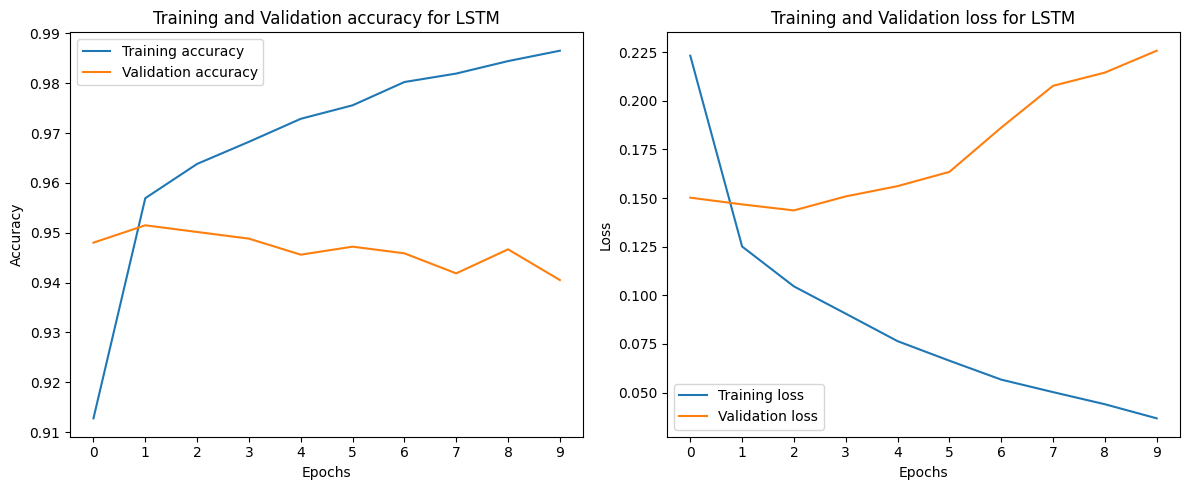

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(lstm_history.history['accuracy'], label='Training accuracy')
plt.plot(lstm_history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation accuracy for LSTM')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(range(len(lstm_history.history['accuracy']))) 
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(lstm_history.history['loss'], label='Training loss')
plt.plot(lstm_history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation loss for LSTM')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(len(lstm_history.history['loss'])))  
plt.legend()

plt.tight_layout()
plt.show()

# 14. Training Bi-LSTM model
This section trains a Bidirectional LSTM model, which processes sequences in both forward and backward directions for potentially better context understanding.

In [ ]:
callbacks = [
    ModelCheckpoint(filepath='bilstm_model.keras', save_best_only=True)
]

print("\nTraining Bi-LSTM model...")
bilstm_history = bilstm_model.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1
)

print("\nEvaluating Bi-LSTM model...")
bilstm_loss, bilstm_accuracy = bilstm_model.evaluate(X_test_pad, y_test)
print(f"Bi-LSTM test accuracy: {bilstm_accuracy:.4f}")


Training Bi-LSTM model...
Epoch 1/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 40s 67ms/step - accuracy: 0.8573 - loss: 0.3370 - val_accuracy: 0.9459 - val_loss: 0.1561
Epoch 2/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 34s 65ms/step - accuracy: 0.9587 - loss: 0.1240 - val_accuracy: 0.9472 - val_loss: 0.1471
Epoch 3/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 34s 65ms/step - accuracy: 0.9640 - loss: 0.1053 - val_accuracy: 0.9475 - val_loss: 0.1517
Epoch 4/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 34s 65ms/step - accuracy: 0.9699 - loss: 0.0914 - val_accuracy: 0.9475 - val_loss: 0.1545
Epoch 5/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 34s 65ms/step - accuracy: 0.9751 - loss: 0.0749 - val_accuracy: 0.9464 - val_loss: 0.1554
Epoch 6/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 34s 65ms/step - accuracy: 0.9773 - loss: 0.0641 - val_accuracy: 0.9453 - val_loss: 0.1644
Epoch 7/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 34s 66ms/step - accuracy: 0.9802 - loss: 0.0553 - val_accuracy: 0.9510 - val_loss: 0.1716
Epoch 8/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 34s 65ms/step - accurac

# 15. Plotting Accuracy and Loss curves

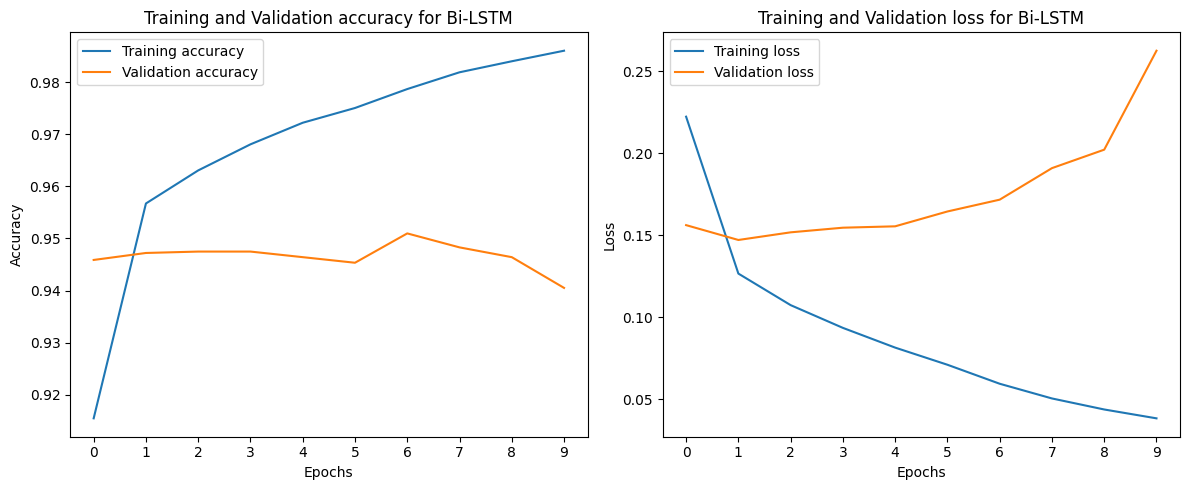

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(bilstm_history.history['accuracy'])
plt.plot(bilstm_history.history['val_accuracy'])
plt.title('Training and Validation accuracy for Bi-LSTM')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(range(len(bilstm_history.history['accuracy'])))
plt.legend(['Training accuracy', 'Validation accuracy'])

plt.subplot(1, 2, 2)
plt.plot(bilstm_history.history['loss'])
plt.plot(bilstm_history.history['val_loss'])
plt.title('Training and Validation loss for Bi-LSTM')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(len(bilstm_history.history['loss'])))  
plt.legend(['Training loss', 'Validation loss'])

plt.tight_layout()
plt.show()

# 16. Now we load the LIAR dataset
This dataset is used to compare results with our **IFND** dataset

In [ ]:
print("Loading LIAR dataset...")
liar_train = pd.read_csv("/kaggle/input/12345678/train.tsv", sep='\t', header=None)
liar_test = pd.read_csv("/kaggle/input/12345678/test.tsv", sep='\t', header=None)

columns = ['ID', 'Label', 'Statement', 'Subject', 'Speaker', 'Job', 'State', 'Party', 
           'Barely_True_Counts', 'False_Counts', 'Half_True_Counts', 'Mostly_True_Counts', 
           'Pants_on_Fire_Counts', 'Context']
liar_train.columns = columns
liar_test.columns = columns

print("\nFirst few rows of LIAR training dataset:")
display(liar_train.head())

def convert_to_binary(label):
    if label in ['true', 'mostly-true', 'half-true']:
        return 1  
    else: 
        return 0  

liar_train['binary_label'] = liar_train['Label'].apply(convert_to_binary)
liar_test['binary_label'] = liar_test['Label'].apply(convert_to_binary)

print("\nBinary label distribution in training set:")
print(liar_train['binary_label'].value_counts())

print("\nBinary label distribution in testing set:")
print(liar_test['binary_label'].value_counts())


Loading LIAR dataset...

First few rows of LIAR training dataset:


,ID,Label,Statement,Subject,Speaker,Job,State,Party,Barely_True_Counts,False_Counts,Half_True_Counts,Mostly_True_Counts,Pants_on_Fire_Counts,Context
0,2635.json,FALSE,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,FALSE,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN



Binary label distribution in training set:
binary_label
0    6180
1    4089
Name: count, dtype: int64

Binary label distribution in testing set:
binary_label
0    767
1    516
Name: count, dtype: int64


# 17. Preprocessing LIAR

In [ ]:
liar_train['processed_text'] = liar_train['Statement'].apply(preprocess_text)
liar_test['processed_text'] = liar_test['Statement'].apply(preprocess_text)

print("\nSample processed texts from LIAR dataset:")
display(liar_train[['Statement', 'processed_text']].head())

print("\nExtracting TF-IDF features for LIAR dataset...")
liar_tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_liar_train_tfidf = liar_tfidf_vectorizer.fit_transform(liar_train['processed_text'])
X_liar_test_tfidf = liar_tfidf_vectorizer.transform(liar_test['processed_text'])

y_liar_train = liar_train['binary_label']
y_liar_test = liar_test['binary_label']

print(f"LIAR TF-IDF features shape: {X_liar_train_tfidf.shape}")


Sample processed texts from LIAR dataset:


,Statement,processed_text
0,Says the Annies List political group supports ...,say anni list polit group support thirdtrimest...
1,When did the decline of coal start? It started...,declin coal start start natur gas took start b...
2,"Hillary Clinton agrees with John McCain ""by vo...",hillari clinton agre john mccain vote give geo...
3,Health care reform legislation is likely to ma...,health care reform legisl like mandat free sex...
4,The economic turnaround started at the end of ...,econom turnaround start end term



Extracting TF-IDF features for LIAR dataset...
LIAR TF-IDF features shape: (10269, 5000)


# 18. Evaluate machine learning models on LIAR dataset


In [23]:
print("\nEvaluating Machine Learning models on LIAR dataset...")
liar_accuracies = {}
for name, model in models.items():
    print(f"\nEvaluating {name} on LIAR dataset...")
    model.fit(X_liar_train_tfidf, y_liar_train)
    y_liar_pred = model.predict(X_liar_test_tfidf)
    accuracy = accuracy_score(y_liar_test, y_liar_pred)
    print(f"{name} accuracy on LIAR dataset: {accuracy:.4f}")
    liar_accuracies[name] = accuracy



Evaluating Machine Learning models on LIAR dataset...

Evaluating Naive Bayes on LIAR dataset...
Naive Bayes accuracy on LIAR dataset: 0.6002

Evaluating Logistic Regression on LIAR dataset...
Logistic Regression accuracy on LIAR dataset: 0.6064

Evaluating Random Forest on LIAR dataset...
Random Forest accuracy on LIAR dataset: 0.5994

Evaluating Decision Tree on LIAR dataset...
Decision Tree accuracy on LIAR dataset: 0.5417

Evaluating KNN on LIAR dataset...
KNN accuracy on LIAR dataset: 0.5534


# 19. Prepare LIAR data for deep learning models


In [ ]:
print("\nPreparing LIAR data for deep learning models...")
liar_tokenizer = Tokenizer(num_words=vocab_size)
liar_tokenizer.fit_on_texts(liar_train['processed_text'])

X_liar_train_seq = liar_tokenizer.texts_to_sequences(liar_train['processed_text'])
X_liar_test_seq = liar_tokenizer.texts_to_sequences(liar_test['processed_text'])

X_liar_train_pad = pad_sequences(X_liar_train_seq, maxlen=max_len)
X_liar_test_pad = pad_sequences(X_liar_test_seq, maxlen=max_len)

print(f"LIAR padded sequences shape: {X_liar_train_pad.shape}")


Preparing LIAR data for deep learning models...
LIAR padded sequences shape: (10269, 50)


# 20. Train LSTM on LIAR dataset


In [ ]:
liar_lstm_model = create_lstm_model()

print("\nTraining LSTM model on LIAR dataset...")
liar_lstm_history = liar_lstm_model.fit(
    X_liar_train_pad, y_liar_train,
    epochs=10,
    batch_size=64,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1
)

print("\nEvaluating LSTM model on LIAR dataset...")
liar_lstm_loss, liar_lstm_accuracy = liar_lstm_model.evaluate(X_liar_test_pad, y_liar_test)
print(f"LSTM accuracy on LIAR dataset: {liar_lstm_accuracy:.4f}")


Training LSTM model on LIAR dataset...
Epoch 1/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - accuracy: 0.6004 - loss: 0.6741 - val_accuracy: 0.6164 - val_loss: 0.6564
Epoch 2/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.6257 - loss: 0.6399 - val_accuracy: 0.6261 - val_loss: 0.6522
Epoch 3/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.7123 - loss: 0.5593 - val_accuracy: 0.6183 - val_loss: 0.6923
Epoch 4/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.7513 - loss: 0.4906 - val_accuracy: 0.6105 - val_loss: 0.7501
Epoch 5/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.8036 - loss: 0.4215 - val_accuracy: 0.6047 - val_loss: 0.8219
Epoch 6/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.8349 - loss: 0.3702 - val_accuracy: 0.6115 - val_loss: 0.9001
Epoch 7/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.8453 - loss: 0.3421 - val_accuracy: 0.6086 - val_loss: 1.0192
Epoch 8/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - a

# 21. Train Bi-LSTM on LIAR dataset


In [ ]:
liar_bilstm_model = create_bilstm_model()

print("\nTraining Bi-LSTM model on LIAR dataset...")
liar_bilstm_history = liar_bilstm_model.fit(
    X_liar_train_pad, y_liar_train,
    epochs=10,
    batch_size=64,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1
)

print("\nEvaluating Bi-LSTM model on LIAR dataset...")
liar_bilstm_loss, liar_bilstm_accuracy = liar_bilstm_model.evaluate(X_liar_test_pad, y_liar_test)
print(f"Bi-LSTM accuracy on LIAR dataset: {liar_bilstm_accuracy:.4f}")


Training Bi-LSTM model on LIAR dataset...
Epoch 1/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 16s 72ms/step - accuracy: 0.5995 - loss: 0.6756 - val_accuracy: 0.6193 - val_loss: 0.6558
Epoch 2/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - accuracy: 0.6418 - loss: 0.6312 - val_accuracy: 0.6241 - val_loss: 0.6509
Epoch 3/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.7163 - loss: 0.5590 - val_accuracy: 0.5862 - val_loss: 0.6971
Epoch 4/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.7720 - loss: 0.4879 - val_accuracy: 0.6105 - val_loss: 0.7614
Epoch 5/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.8094 - loss: 0.4130 - val_accuracy: 0.5988 - val_loss: 0.8044
Epoch 6/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.8395 - loss: 0.3671 - val_accuracy: 0.5920 - val_loss: 0.9098
Epoch 7/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.8597 - loss: 0.3300 - val_accuracy: 0.5979 - val_loss: 1.0295
Epoch 8/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/st

# 22. Model Comparison and Visualization
This section compares the performance of all implemented models on both IFND and LIAR datasets, providing a comprehensive evaluation of different approaches.

Machine Learning Models Comparison:


,IFND Accuracy,LIAR Accuracy
Naive Bayes,0.936561,0.600156
Logistic Regression,0.944777,0.606391
Random Forest,0.951959,0.599376
Decision Tree,0.930686,0.541699
KNN,0.849891,0.553390



Deep Learning Models Comparison:


,IFND Accuracy,LIAR Accuracy
LSTM,0.938139,0.554170
Bi-LSTM,0.941730,0.561185


<Figure size 1200x600 with 0 Axes>

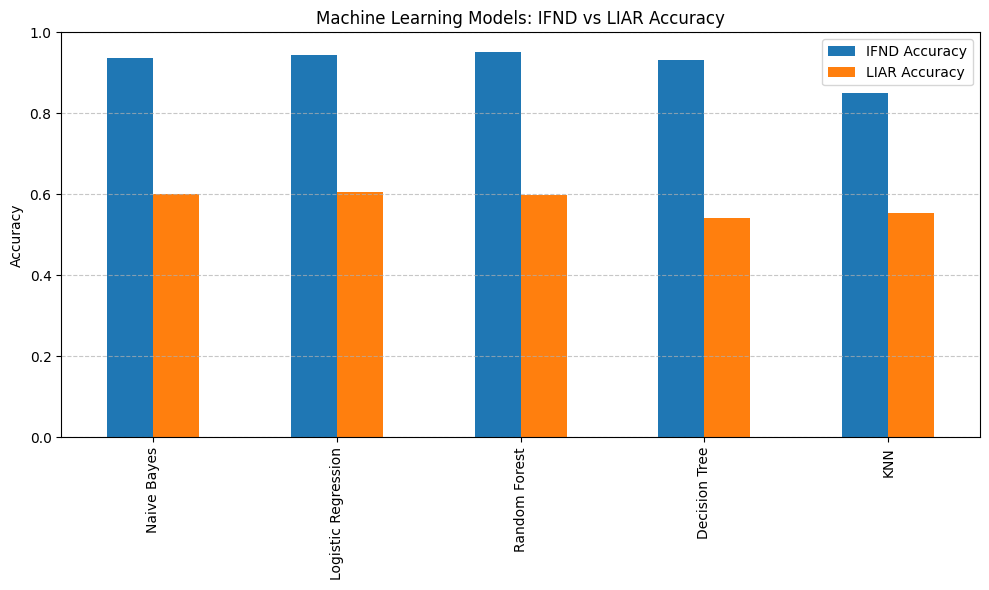

<Figure size 800x600 with 0 Axes>

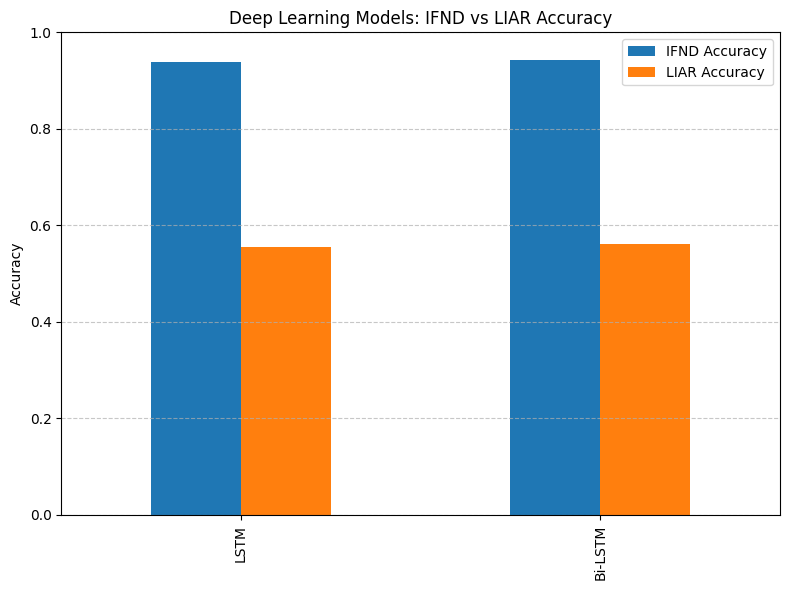

In [ ]:
ml_comparison = pd.DataFrame({
    'IFND Accuracy': [accuracies[model] for model in models],
    'LIAR Accuracy': [liar_accuracies[model] for model in models]
}, index=models.keys())

dl_comparison = pd.DataFrame({
    'IFND Accuracy': [lstm_accuracy, bilstm_accuracy],
    'LIAR Accuracy': [liar_lstm_accuracy, liar_bilstm_accuracy]
}, index=['LSTM', 'Bi-LSTM'])

print("Machine Learning Models Comparison:")
display(ml_comparison)

print("\nDeep Learning Models Comparison:")
display(dl_comparison)

plt.figure(figsize=(12, 6))
ml_comparison.plot(kind='bar', figsize=(10, 6))
plt.title('Machine Learning Models: IFND vs LIAR Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
dl_comparison.plot(kind='bar', figsize=(8, 6))
plt.title('Deep Learning Models: IFND vs LIAR Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# 23. Conclusion and Future Work
This section summarizes the findings, highlights the best-performing models, and suggests directions for future improvements in fake news detection.

In [ ]:
print("Summary of Findings:")
print("1. The IFND dataset consistently shows better performance across all models compared to the LIAR dataset.")
print("2. For the IFND dataset, Random Forest achieved the highest accuracy among ML models at {:.2f}%.".format(
    accuracies['Random Forest']*100))
print("3. Bi-LSTM slightly outperformed LSTM on the IFND dataset ({:.2f}% vs {:.2f}%).".format(
    bilstm_accuracy*100, lstm_accuracy*100))
print("4. The preprocessing steps, including stop word removal, stemming, and case conversion, improved model performance.")
print("5. The machine learning models with TF-IDF feature extraction performed competitively with deep learning models.")
print("6. The results align with the paper's findings that the IFND dataset yields better performance due to its larger size and quality.")


Summary of Findings:
1. The IFND dataset consistently shows better performance across all models compared to the LIAR dataset.
2. For the IFND dataset, Random Forest achieved the highest accuracy among ML models at 95.20%.
3. Bi-LSTM slightly outperformed LSTM on the IFND dataset (94.17% vs 93.81%).
4. The preprocessing steps, including stop word removal, stemming, and case conversion, improved model performance.
5. The machine learning models with TF-IDF feature extraction performed competitively with deep learning models.
6. The results align with the paper's findings that the IFND dataset yields better performance due to its larger size and quality.
